In [125]:
!pip install visdom==0.1.7 wandb rasterio -q
!pip install einops -q
!pip install einsum -q

In [126]:
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional
import torch.nn.functional as F
from torch import autograd
import torch.optim as optim

import os
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import GroupShuffleSplit
from matplotlib import pyplot as plt
plt.switch_backend('agg')


from torchvision.utils import save_image, make_grid
import datetime
import pickle
from tqdm import tqdm
import itertools

import math


import argparse
import pandas as pd
import time
import random
from datetime import datetime
from pathlib import Path

from PIL import Image
import torchvision.transforms as transforms
import torch.nn.utils.rnn as rnn
import json
from torch.utils.data import DataLoader
from torch.utils.data.sampler import WeightedRandomSampler, SubsetRandomSampler
from torchvision import models
import warnings
warnings.filterwarnings('ignore')

In [127]:
pd.read_csv('gs://data_ctm/data/data/africa_crop_type_mapping/ghana/.ipynb_checkpoints/list_eval_partition-checkpoint.csv')

,Unnamed: 0,id,partition
0,0,4007,0
1,1,3962,0
2,2,2635,0
3,3,3247,0
4,4,3964,0
...,...,...,...
2876,2876,515,2
2877,2877,1334,2
2878,2878,2345,2
2879,2879,3960,2


In [128]:
!gsutil ls gs://data_ctm/data/data/africa_crop_type_mapping/ghana/

gs://data_ctm/data/data/africa_crop_type_mapping/ghana/list_eval_partition.csv
gs://data_ctm/data/data/africa_crop_type_mapping/ghana/.ipynb_checkpoints/
gs://data_ctm/data/data/africa_crop_type_mapping/ghana/npy/
gs://data_ctm/data/data/africa_crop_type_mapping/ghana/planet/
gs://data_ctm/data/data/africa_crop_type_mapping/ghana/s1/
gs://data_ctm/data/data/africa_crop_type_mapping/ghana/s2/
gs://data_ctm/data/data/africa_crop_type_mapping/ghana/truth/


In [129]:
from google.colab import drive
drive.mount('/content/drive')

### 1. The right key of .npz of files to access the data inside the file.

In [130]:
import numpy as np

# Load the file
data = np.load('/content/data/africa_crop_type_mapping/ghana/truth/ghana_000000.npz')

# Print out all keys
print(data.files)


['truth']


#### 2. Field Shape

In [133]:
import numpy as np

# Get a list of all .npz files in the directory
files = [f for f in os.listdir('/content/data/africa_crop_type_mapping/ghana/npy') if f.endswith('.npz')]

# Randomly select 12 files
selected_files = random.sample(files, 12)

for i, file in enumerate(selected_files):
    # Load the file
    data = np.load(f'/content/data/africa_crop_type_mapping/ghana/npy/{file}')

    # Access the array with the key 'planet'
    array = data['planet']

    # Print out the shape of the array
    print(f'Shape of {file}: {array.shape}')


Shape of ghana_002080.npz: (4, 211, 211, 119)
Shape of ghana_000203.npz: (4, 211, 211, 117)
Shape of ghana_000150.npz: (4, 211, 211, 115)
Shape of ghana_003161.npz: (4, 211, 211, 129)
Shape of ghana_000640.npz: (4, 211, 211, 130)
Shape of ghana_003797.npz: (4, 211, 211, 100)
Shape of ghana_000028.npz: (4, 211, 211, 128)
Shape of ghana_003367.npz: (4, 211, 211, 130)
Shape of ghana_002934.npz: (4, 211, 211, 128)
Shape of ghana_003158.npz: (4, 212, 212, 104)
Shape of ghana_003532.npz: (4, 211, 211, 111)
Shape of ghana_000709.npz: (4, 211, 211, 133)


### 3. Display fields
#### display structure of field

In [135]:
import numpy as np

# Load the file
data = np.load('/content/data/africa_crop_type_mapping/ghana/npy/ghana_000000.npz')

# Print out all keys
print(data.files)

# ['planet', 's1', 's2', 's2_cloudmask']


['planet', 's1', 's2', 's2_cloudmask']


* ‘planet’ could refer to PlanetScope satellite imagery.
* ‘s1’ might be Sentinel-1 satellite data.
* ‘s2’ could be Sentinel-2 satellite data.
* ‘s2_cloudmask’ might be a cloud mask for the Sentinel-2 data.

### 4. Display fields with it corresponding crop

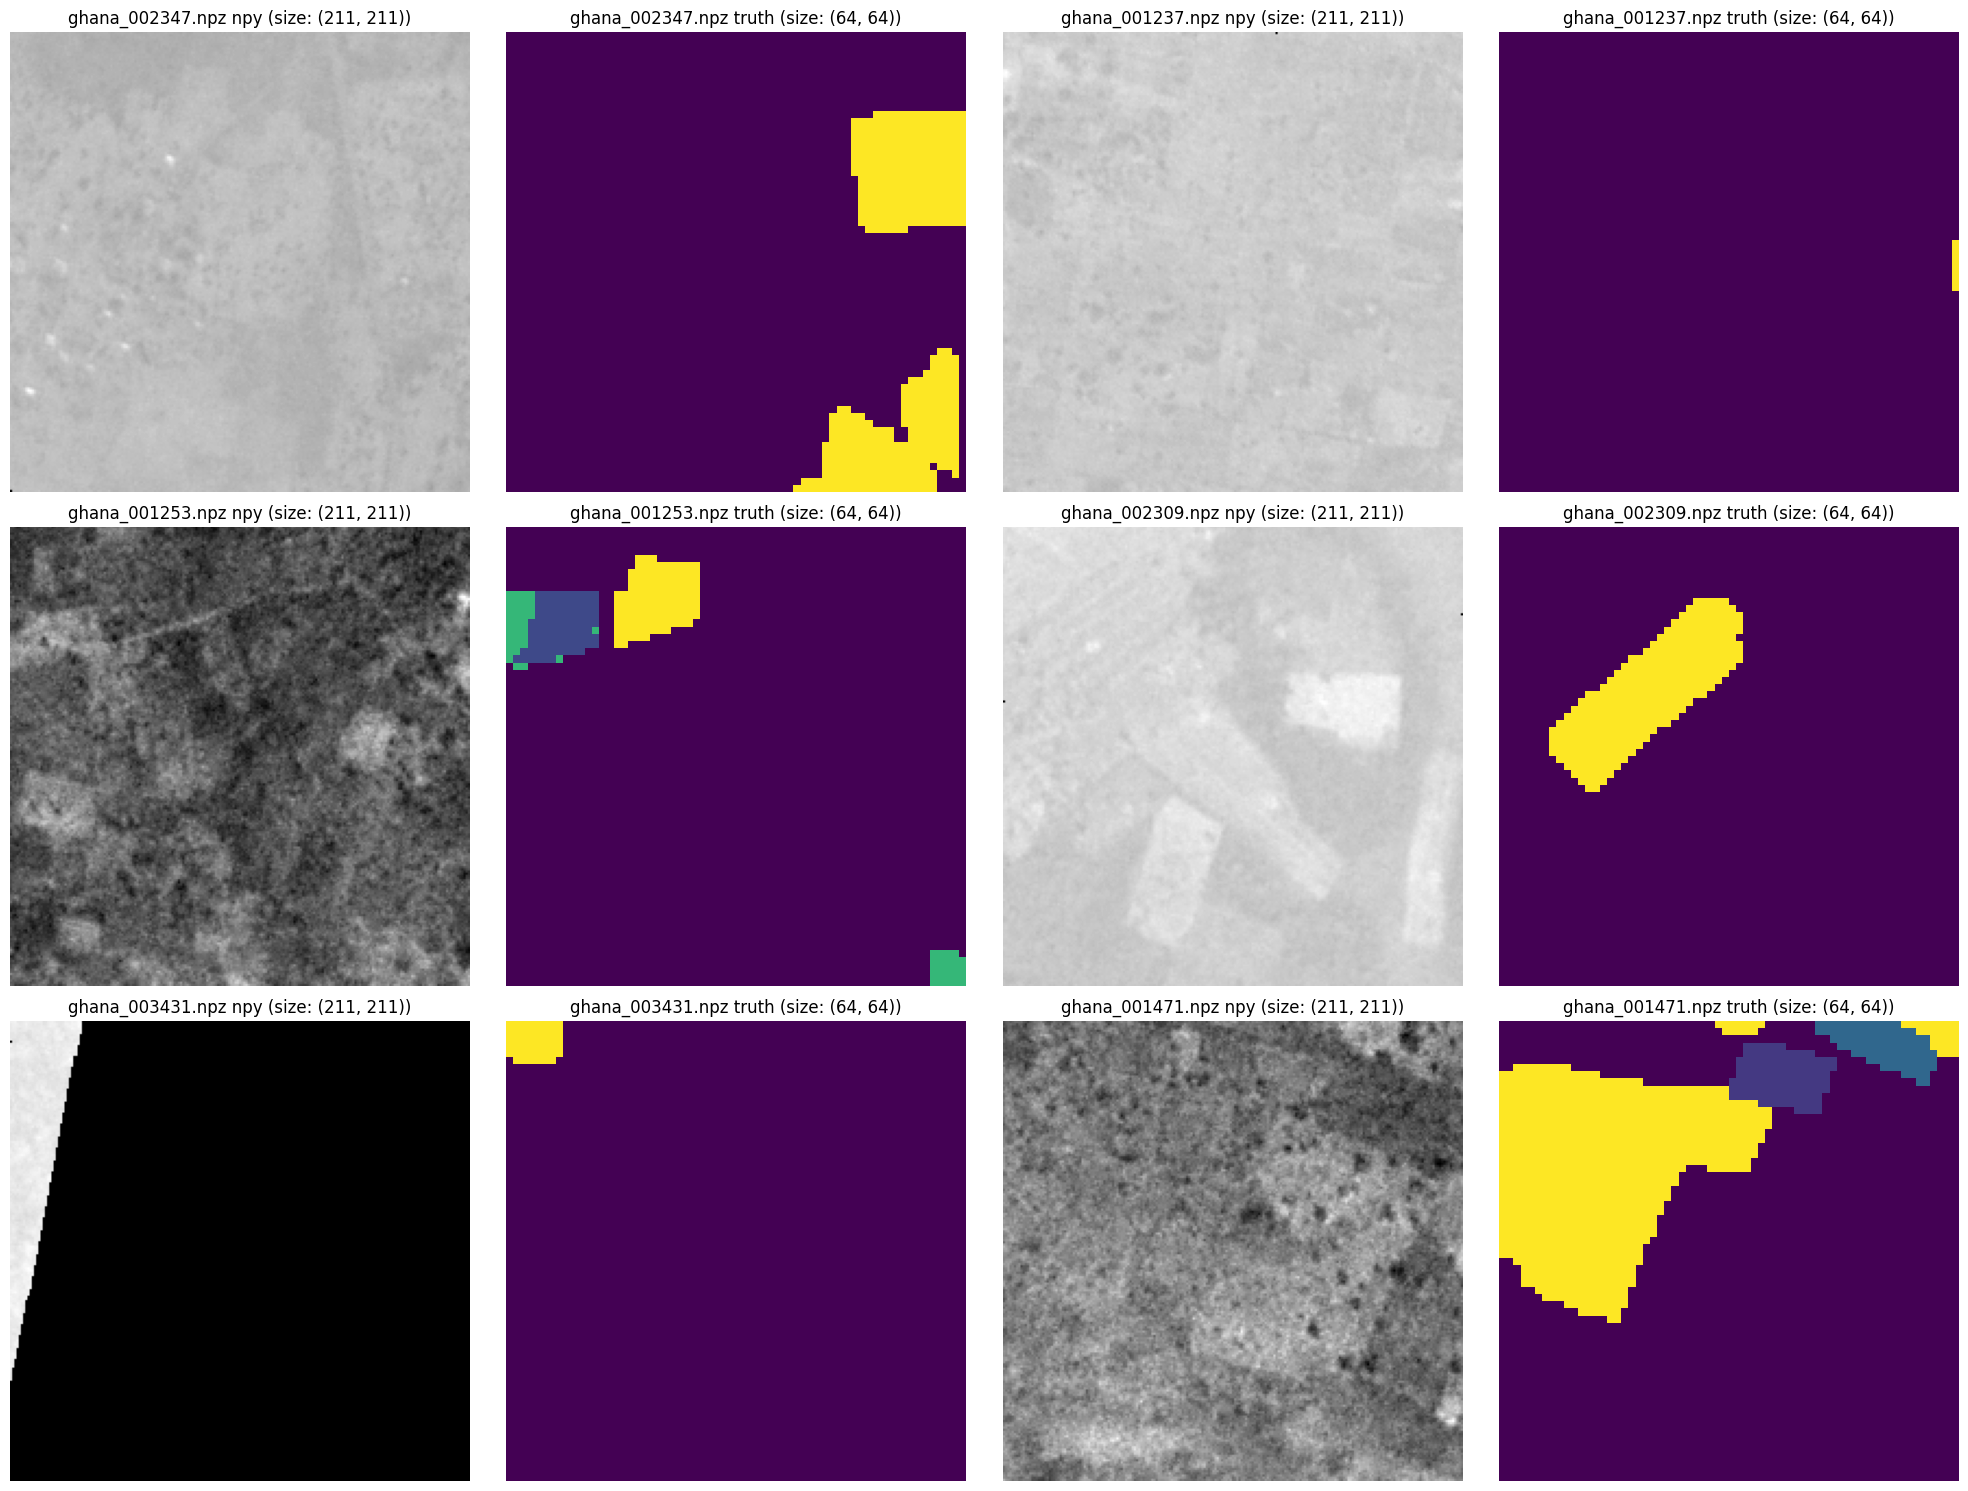

In [165]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random

# Get a list of all .npz files in the directories
files_npy = [f for f in os.listdir('/content/data/africa_crop_type_mapping/ghana/npy') if f.endswith('.npz')]
files_truth = [f for f in os.listdir('/content/data/africa_crop_type_mapping/ghana/truth/') if f.endswith('.npz')]

# Ensure that the files in both directories have a common identifier
common_files = list(set(files_npy) & set(files_truth))

# Randomly select 6 common files (since we want to display 2 images per file)
selected_files = random.sample(common_files, 6)

# Create a new figure with 4 columns and 3 rows
fig, axs = plt.subplots(3, 4, figsize=(20, 15))

for i, file in enumerate(selected_files):
    # Load the files
    data_npy = np.load(f'/content/data/africa_crop_type_mapping/ghana/npy/{file}')
    data_truth = np.load(f'/content/data/africa_crop_type_mapping/ghana/truth/{file}')

    # Access the arrays with the keys 'planet' and 'truth'
    array_npy = data_npy['planet']
    array_truth = data_truth['truth']

    # Choose specific indices
    channel_index = 0
    time_index = 0

    # Get a 2D slice
    array_2d_slice_npy = array_npy[channel_index, :, :, time_index]

    # Display the 2D slices
    axs[i // 2, 2 * (i % 2)].imshow(array_2d_slice_npy, cmap='gray')
    axs[i // 2, 2 * (i % 2)].axis('off')
    axs[i // 2, 2 * (i % 2)].set_title(f'{file} npy (size: {array_2d_slice_npy.shape})')

    axs[i // 2, 2 * (i % 2) + 1].imshow(array_truth)
    axs[i // 2, 2 * (i % 2) + 1].axis('off')
    axs[i // 2, 2 * (i % 2) + 1].set_title(f'{file} truth (size: {array_truth.shape})')

plt.tight_layout()
plt.show()

### 5. Transform single-channel grayscale masks to pseudo-color masks with data augmentation

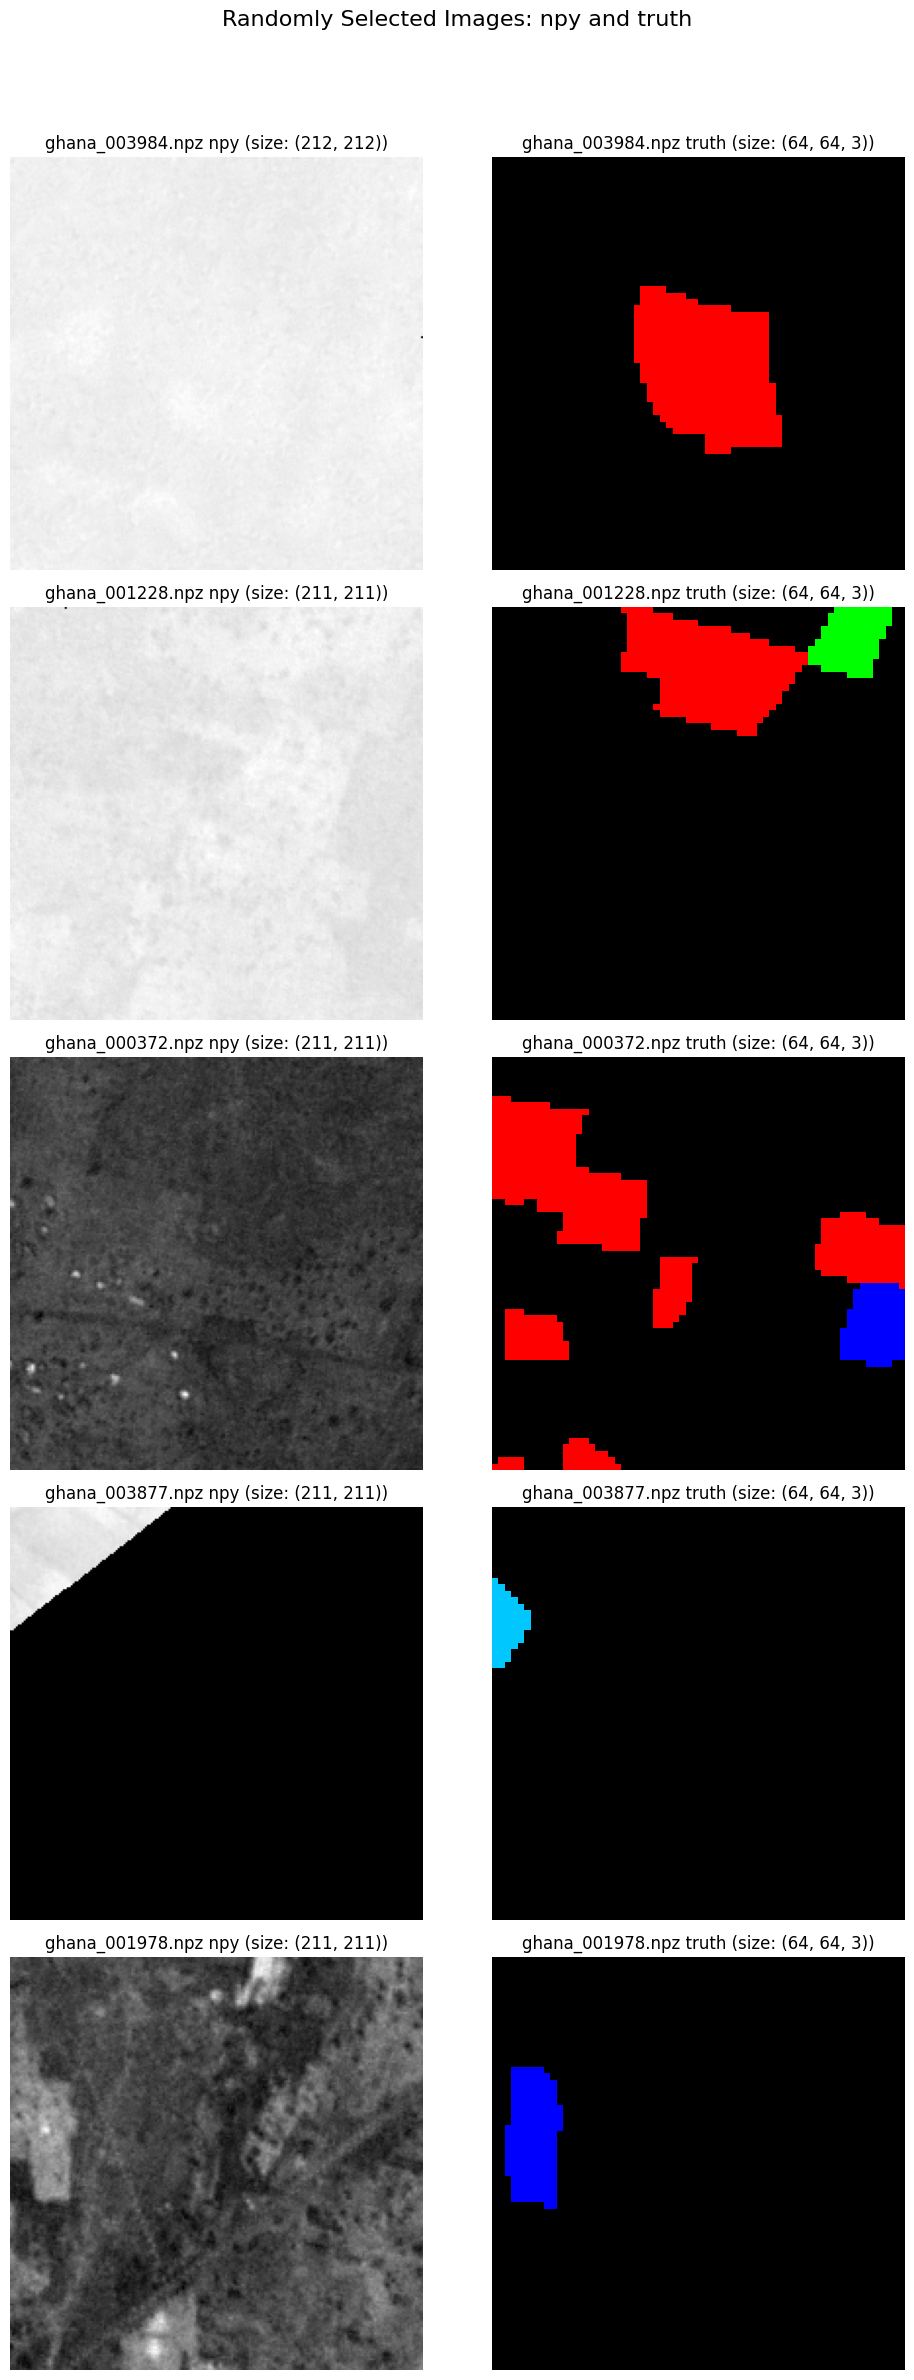

In [169]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random

# Get a list of all .npz files in the directories
files_npy = [f for f in os.listdir('/content/data/africa_crop_type_mapping/ghana/npy') if f.endswith('.npz')]
files_truth = [f for f in os.listdir('/content/data/africa_crop_type_mapping/ghana/truth/') if f.endswith('.npz')]

# Ensure that the files in both directories have a common identifier
common_files = list(set(files_npy) & set(files_truth))

# Randomly select 5 common files (since we want to display 2 images per file)
selected_files = random.sample(common_files, 5)

# Create a new figure with 5 rows and 2 columns
fig, axs = plt.subplots(5, 2, figsize=(10, 25))

for i, file in enumerate(selected_files):
    # Load the files
    data_npy = np.load(f'/content/data/africa_crop_type_mapping/ghana/npy/{file}')
    data_truth = np.load(f'/content/data/africa_crop_type_mapping/ghana/truth/{file}')

    # Access the arrays with the keys 'planet' and 'truth'
    array_npy = data_npy['planet']
    array_truth = data_truth['truth']
    array_truth[array_truth>4]=0
    # Choose specific indices
    channel_index = 0
    time_index = 0

    # Get a 2D slice
    array_2d_slice_npy = array_npy[channel_index, :, :, time_index]

    color_mappings = {
    0: (0, 0, 0),    # background (black)
    1: (0, 0, 255),  # red
    2: (255, 0, 0),  # blue
    3: (0, 200, 255),  # yellow
    4: (0, 255, 0)    # green
    }

    # Create an empty RGB image with the same shape as the single-channel mask
    rgb_mask = np.zeros((*array_truth.shape, 3), dtype=np.uint8)

    # Iterate over each unique label in the single-channel mask
    for label, color in color_mappings.items():
        # Find pixels with the current label in the single-channel mask
        mask_indices = array_truth == label

        # Assign the corresponding color to those pixels in the RGB mask
        rgb_mask[mask_indices] = color

    # Display the npy image without augmentation
    axs[i, 0].imshow(array_2d_slice_npy, cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 0].set_title(f'{file} npy (size: {array_2d_slice_npy.shape})')

    # Display the truth image without augmentation
    axs[i, 1].imshow(rgb_mask)
    axs[i, 1].axis('off')
    axs[i, 1].set_title(f'{file} truth (size: {rgb_mask.shape})')

# Add a title to the entire subplot grid
fig.suptitle('Randomly Selected Images: npy and truth', fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to include title
# Save the figure as a PNG file
plt.savefig('images.png')
plt.show()
